In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import linregress
import seaborn as sns
import pymc3 as pm
import arviz as az
import plot_helpers
import data_helpers
from data_helpers import gate_dataframe, canonical_data_frame
from sklearn.mixture import GaussianMixture 
from sklearn.cluster import KMeans

In [2]:
PREGATED_DATA = os.path.exists('gated_negative_controls.csv')

# Loading the Negative Controls data

In [3]:
if PREGATED_DATA:
    # Shortcut
    df = pd.read_csv('gated_negative_controls.csv')
else:
    df = pd.read_csv('negative_controls.csv')

In [4]:
df.set_index(['strain_name', 'inc_temp_degrees', 'inc_time_2_hrs', 'media', 'od', 'plate_id', 'replicate', 'event'], drop=True, inplace=True)

# Gate the Negative Control Data

In [5]:
if 'lab_id' not in df.index.names:
    df.set_index('lab_id', append=True, drop=True, inplace=True)
if 'well' not in df.index.names:
    df.set_index('well', append=True, drop=True, inplace=True)
print(df.index.names)
if not PREGATED_DATA:
    df = gate_dataframe(df)

['strain_name', 'inc_temp_degrees', 'inc_time_2_hrs', 'media', 'od', 'plate_id', 'replicate', 'event', 'lab_id', 'well']


# Remove data with 16h recovery time

There are not many of these -- only three plates -- and they were done with an earlier version of the protocol.  They also seem to have other oddities.

In [6]:
if not PREGATED_DATA:
    df.reset_index(inplace=True, drop=False)
    print('Experiments with 16h recovery time:')
    print(df[df['inc_time_1_hrs'] == 16].lab_id.unique())
    print('Experiments with 18h recovery time:')
    print(df[df['inc_time_1_hrs'] == 18].lab_id.unique())
    df = df[df['inc_time_1_hrs'] == 18]
else:
    assert df[df['inc_time_1_hrs'] == 16].empty

# Add logs for scatter values

In [7]:
if PREGATED_DATA:
    assert 'log_FSC_A' in df.columns
    assert 'log_SSC_A' in df.columns
else:
    df.loc[:, 'log_FSC_A'] = np.log10(df.FSC_A + 1)
    df.loc[:, 'log_SSC_A'] = np.log10(df.SSC_A + 1)

    # Drop bad log values

    rs = {
        'log_FSC_A': np.inf, 
        'log_FSC_A': -np.inf,
        'log_SSC_A': np.inf, 
        'log_SSC_A': -np.inf,
         }

    df = df.replace(to_replace=rs, value=np.nan)
    df.dropna(subset=['log_FSC_A', 'log_SSC_A'], inplace=True)

# Try to make models with simple regression

## Unimodal

In [8]:
df.log_FSC_A.values, df.log_SSC_A.values

(array([4.85311998, 4.67276265, 4.61557132, ..., 4.59636614, 4.92842146,
        4.87836666]),
 array([5.53189641, 5.48825874, 5.38165288, ..., 4.97894249, 5.42656656,
        5.31249682]))

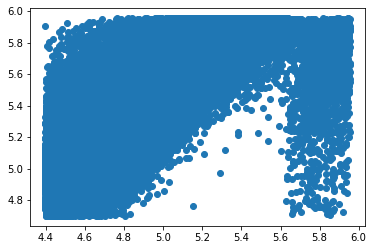

In [9]:
plt.scatter(df.log_FSC_A.values, df.log_SSC_A.values)

<AxesSubplot:xlabel='FSC_A', ylabel='SSC_A'>

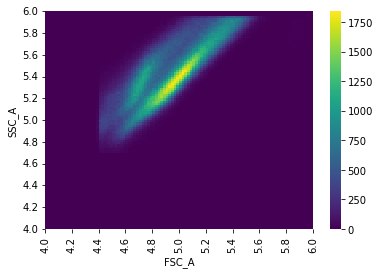

In [10]:
plot_helpers.make_heatmap(plot_helpers.point_cloud_to_histogram(df, logscale=True), logscale=True)

# Try simple linear regression

In [11]:

lr_result = linregress(df.log_FSC_A.values, df.log_SSC_A.values)
lr_result

LinregressResult(slope=0.8799736457572654, intercept=1.0964177226622844, rvalue=0.8082327739205489, pvalue=0.0, stderr=0.0006487783147381917, intercept_stderr=0.0032024821205543772)

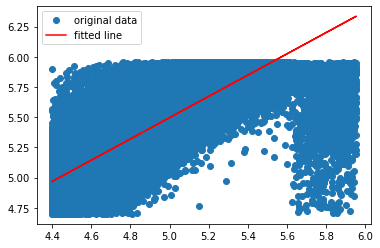

In [12]:
def plot_regression(x, y, res):
    ax = plt.subplot(111)
    
    ax.plot(x, y, 'o', label='original data')

    ax.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
    
    plt.legend()

    plt.show()
    
plot_regression(df.log_FSC_A, df.log_SSC_A, lr_result)

# Clustered linear regression with GLM

Adapted [code from StackExchange](https://stackoverflow.com/a/47960321/289934).

In [13]:
x = df['log_FSC_A']
y = df['log_SSC_A']
data = np.vstack([x, y]).T
model = GaussianMixture (n_components=2).fit(data)

In [14]:
model

GaussianMixture(n_components=2)

In [15]:
model.converged_

True

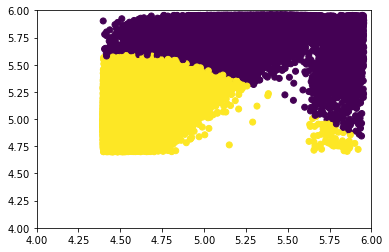

In [16]:
plt.scatter(x, y, c=model.predict(data))
plt.gca().set_xlim(4, 6)
plt.gca().set_ylim(4, 6)
plt.show()

# Clustered regression with GLM, 3 Clusters

In [17]:
x = df['log_FSC_A']
y = df['log_SSC_A']
data = np.vstack([x, y]).T
model = GaussianMixture (n_components=3).fit(data)

In [18]:
model

GaussianMixture(n_components=3)

In [19]:
model.converged_

True

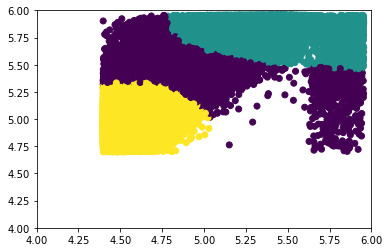

In [20]:
plt.scatter(x, y, c=model.predict(data))
plt.gca().set_xlim(4, 6)
plt.gca().set_ylim(4, 6)
plt.show()

In [21]:
ps = model.predict(data)

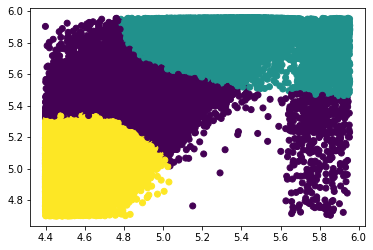

In [22]:
ax = plt.scatter(x, y, c=model.predict(data))
plt.show()

# Clustering Ratios

In [24]:
df.loc[:, 'scatter_log_ratio'] = df['log_SSC_A'] / df['log_FSC_A']
df.loc[:, 'scatter_log_diff'] = df['log_SSC_A'] - df['log_FSC_A']

In [27]:
x = df['scatter_log_ratio'].values
x = np.reshape(x, (-1,1))
model = KMeans(n_clusters=2).fit(x)

In [28]:
df.loc[:, 'cluster_index'] = model.predict(x)

<AxesSubplot:xlabel='FSC_A', ylabel='SSC_A'>

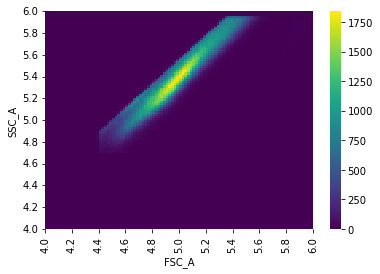

In [29]:
plot_helpers.make_heatmap(plot_helpers.point_cloud_to_histogram(df[df['cluster_index'] == 0], logscale=True), logscale=True)

<AxesSubplot:xlabel='FSC_A', ylabel='SSC_A'>

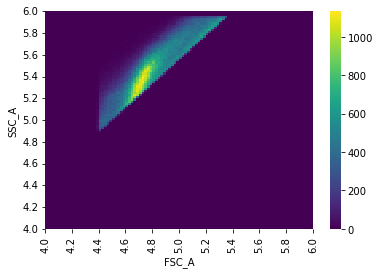

In [30]:
plot_helpers.make_heatmap(plot_helpers.point_cloud_to_histogram(df[df['cluster_index'] == 1], logscale=True), logscale=True)

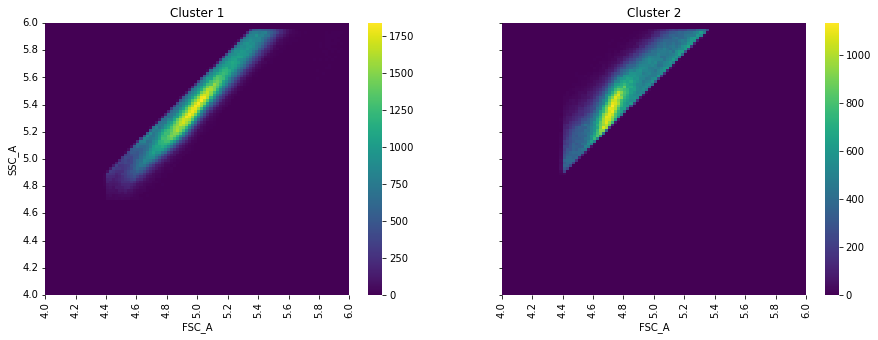

In [32]:
fig, axeses = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)
plot_helpers.make_heatmap(plot_helpers.point_cloud_to_histogram(df[df['cluster_index'] == 0], logscale=True), 
                          logscale=True, 
                          ax=axeses[0] )
axeses[0].set_title('Cluster 1') ; axeses[1].set_title('Cluster 2')
plot_helpers.make_heatmap(plot_helpers.point_cloud_to_histogram(df[df['cluster_index'] == 1], logscale=True),
                          logscale=True,
                          ax=axeses[1])
axeses[1].set_ylabel("");
fig.savefig('two_cluster_negative_controls.pdf', format='pdf');